In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
#download dataset
df = pd.read_csv("https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv", sep = ",")
#df.head(5)
#df.tail(5)

In [5]:
class Model(nn.Module):
  #input layer (10 principal components of wine) --> H1 --> H2 --> output
  #fc1 = "fully connected" layer 1
  def __init__(self, in_features=10, h1 = 9, h2 = 9, out_features=3):
    super().__init__() #instantiates nn.module
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x


In [6]:
#establish X and y
X = df.drop('Wine', axis = 1) #axis = 1 tells pandas to drop a column
y = df['Wine']

#convert to np arrays, since sci-kit learn requires np array objects
#np arrays are also faster
X = X.values
y = y.values

le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
#split data into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#fit pca
pca_full = PCA().fit(X_train_scaled)
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

#find number of components satisfying 95% variance
n_components_95 = (cumulative_variance >= 0.95).argmax() + 1

#re-evaluate pca
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#convert to tensors for training
X_train_pca = torch.FloatTensor(X_train_pca)
X_test_pca = torch.FloatTensor(X_test_pca)


In [ ]:
#pick a seed for reproducibility
torch.manual_seed(300)
# Create an instance of a model
model = Model()

In [10]:
#set loss criterion
criterion = nn.CrossEntropyLoss()
#set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
#train model
epochs = 10000
lossList = []
best_loss = 10

for i in range(epochs):
    y_pred = model(X_train_pca)
    loss = criterion(y_pred, y_train)
    lossList.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(loss)

    if loss < best_loss:
      best_loss = loss
      torch.save(model.state_dict(), 'best.pt')

model.load_state_dict(torch.load('best.pt'))


tensor(1.0998, grad_fn=<NllLossBackward0>)


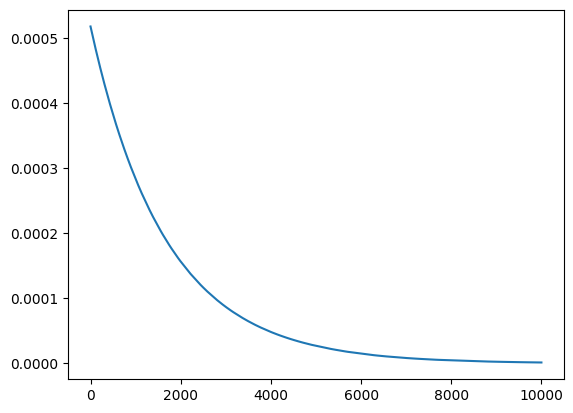

In [108]:
plt.plot(range(epochs), lossList)
plt.show()

In [ ]:
import torch #cuz github is acting stupid

correct = 0
with torch.no_grad():
    for i in range(len(X_test_pca)):
        x = X_test_pca[i].unsqueeze(0)
        y_val = model(x)

        predicted = y_val.argmax(dim=1).item()
        if predicted == y_test[i].item():
            correct += 1

print(f"Correct: {correct}")
print(f"Total: {len(X_test_pca)}")
print(f"Accuracy: {correct / len(X_test_pca)}")

NameError: name 'torch' is not defined